# Training a KAN network for CIFAR10 Image classification

The aim of this tutorial is to train an MNIST image classification using the Kolmogorov Arnold Networks. The implementation is based on Pytorch and provides a walkthrough of how a simple neural network can be trained using KANs.

## Load the libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

## Define transforms and data loaders

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:48<00:00, 3490475.09it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Lets see how the images look once they are in dataloader!

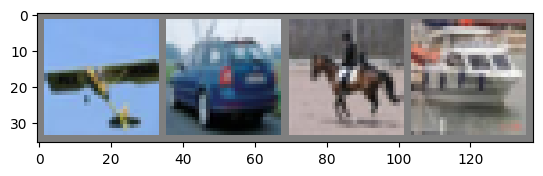

plane car   horse ship 


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Define a Kolmogorov Neural Network

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Define a Loss function and an Optimizer

A classification cross entropy loss and SGD with momentum

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the network

Time to make things more interesting! Here, we have to loop over our data iterator and give the inputs to the network.

In [6]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.194
[1,  4000] loss: 1.903
[1,  6000] loss: 1.706
[1,  8000] loss: 1.605
[1, 10000] loss: 1.505
[1, 12000] loss: 1.471
[2,  2000] loss: 1.388
[2,  4000] loss: 1.388
[2,  6000] loss: 1.388
[2,  8000] loss: 1.322
[2, 10000] loss: 1.280
[2, 12000] loss: 1.286
[3,  2000] loss: 1.217
[3,  4000] loss: 1.203
[3,  6000] loss: 1.219
[3,  8000] loss: 1.182
[3, 10000] loss: 1.175
[3, 12000] loss: 1.175
[4,  2000] loss: 1.098
[4,  4000] loss: 1.094
[4,  6000] loss: 1.098
[4,  8000] loss: 1.111
[4, 10000] loss: 1.100
[4, 12000] loss: 1.096
[5,  2000] loss: 0.997
[5,  4000] loss: 1.038
[5,  6000] loss: 1.054
[5,  8000] loss: 1.041
[5, 10000] loss: 1.043
[5, 12000] loss: 1.057
[6,  2000] loss: 0.947
[6,  4000] loss: 0.978
[6,  6000] loss: 0.995
[6,  8000] loss: 0.975
[6, 10000] loss: 1.000
[6, 12000] loss: 0.996
[7,  2000] loss: 0.891
[7,  4000] loss: 0.931
[7,  6000] loss: 0.946
[7,  8000] loss: 0.943
[7, 10000] loss: 0.966
[7, 12000] loss: 0.974
[8,  2000] loss: 0.861
[8,  4000] 

Once the training is done, saving the model here!

In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## Test the network on test data

Lets see how our model holds on the test data, but first visualization to see how the images look!

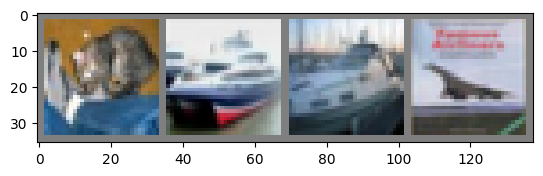

GroundTruth:  cat   ship  ship  plane


In [8]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, lets load the model which is trained. (note: saving and loading the model is an optional step.)

In [9]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [10]:
outputs = net(images)

The outputs are the probabilities/scores for the 10 classes. The higher the score, the more the network thinks that the image belongs to that particular class. Lets see which categories are predicted by the model!

In [11]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  car   ship 


## Accuracy of the model

A very important step is to see whats the overall performance of the network. 

In [12]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 62 %


Seems like the network is giving good performance, but this is an overall accuracy of the model. Lets see what are the classes that model is performing well on! 

In [13]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 69.1 %
Accuracy for class: car   is 81.8 %
Accuracy for class: bird  is 41.8 %
Accuracy for class: cat   is 45.7 %
Accuracy for class: deer  is 50.4 %
Accuracy for class: dog   is 51.2 %
Accuracy for class: frog  is 70.9 %
Accuracy for class: horse is 68.5 %
Accuracy for class: ship  is 76.2 %
Accuracy for class: truck is 70.9 %
